<a href="https://colab.research.google.com/github/KotiKommineni/GPU_Programming/blob/main/gpu_programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! ls


! nvcc --version


!git --version


! git clone https://github.com/andreinechaev/nvcc4jupyter.git

%cd nvcc4jupyter/

%load_ext nvcc_plugin


drive  nvcc4jupyter  sample_data
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
git version 2.25.1
fatal: destination path 'nvcc4jupyter' already exists and is not an empty directory.
/content/nvcc4jupyter
directory /content/nvcc4jupyter/src already exists
Out bin /content/nvcc4jupyter/result.out


In [2]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [3]:
%%cu
#include <iostream>
int main() 
{
    std::cout << "Hello world\n";
    return 0;
}

Hello world



In [4]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "stdio.h"
void addArrays(int*a, int*b, int*c, int count)
{
    for(int i=0; i <count;i++)
    {
         c[i]=a[i]+b[i];
    }
   
}

int main()
{
    const int count = 5;
    int a[] = {1,2,3,4,5};
    int b[] = {10,20,30,40,50};
    int c[count];
    
    addArrays(a,b,c,count);
 
    for(int i=0; i <count;i++)
    {
         printf("%d  ",c[i]);
    }
 return 0;
}

11  22  33  44  55  


In [5]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "stdio.h"

void addArrays(int*a, int*b, int*c, int i)
{
         c[i]=a[i]+b[i];
}

int main()
{
    const int count = 5;
    int a[] = {1,2,3,4,5};
    int b[] = {10,20,30,40,50};
    int c[count];
    
    for(int i=0; i <count;i++)
    {
     addArrays(a,b,c,i);
    }
 
    for(int i=0; i <count;i++)
    {
         printf("%d  ",c[i]);
    }
 return 0;
}

11  22  33  44  55  


In [6]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "stdio.h"

__global__ void addArrays(int*a, int*b, int*c)
{
    int i = threadIdx.x;
         c[i]=a[i]+b[i];
}

int main()
{
    const int count = 5;
    const int size = count*sizeof(int);
    int ha[] = {1,2,3,4,5};
    int hb[] = {10,20,30,40,50};
    int hc[count];
    
    int *da, *db, *dc;
    cudaMalloc(&da, size);
    cudaMalloc(&da, size);
    cudaMalloc(&da, size);
 
    cudaMemcpy(da,ha,size,cudaMemcpyHostToDevice);
    cudaMemcpy(da,ha,size,cudaMemcpyHostToDevice);
 
    addArrays<<<1,count>>>(da,db,dc);
    
    cudaMemcpy(hc,dc,size,cudaMemcpyDeviceToHost);

    for(int i=0; i < count; i++)
    {
         printf("%d  ",hc[i]);
    }
 return 0;
}

0  0  -2089805168  22031  1339103648  


**Location Qualifiers**


*   __ __global__ __

         Defines a Kernel.

         Runs on the GPU,  called from the CPU

         Executed with <<dim3>>> arguments

*   __ __device__ __

          Runs on the GPU, called from GPU.
         * Can be used for variables too.

* __ __host__ __

          Runs on the CPU, called from the CPU

* Qualifiers can be mixed
         * E.g __ __host__ __ __ __device__ __ foo()
         * Code compiled for both CPU and GPU
         * Useful for testing








In [7]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <iostream>
using namespace std;

int main()
{
    int count;
    cudaGetDeviceCount(&count);
    
    cudaDeviceProp prop;
    for(int i = 0; i<count;++i)
    {
        cudaGetDeviceProperties(&prop,i);
     cout << " Device " << i << ": " << prop.name << endl;
     cout << " Compute capability: " << prop.major << "." << prop.minor << endl;
     cout << " Max grid dimensions: (" << 
             prop.maxGridSize[0] << "x " <<
             prop.maxGridSize[1] << "x " <<
             prop.maxGridSize[2] << ")" << endl;

      cout << " Max block dimensions: (" << 
             prop.maxThreadsDim[0] << "x " <<
             prop.maxThreadsDim[1] << "x " <<
             prop.maxThreadsDim[2] << ")" << endl;    

    }
 getchar();
 return 0;
}

 Device 0: Tesla T4
 Compute capability: 7.5
 Max grid dimensions: (2147483647x 65535x 65535)
 Max block dimensions: (1024x 1024x 64)



Parallell Programming Patterns

Rules of the Game

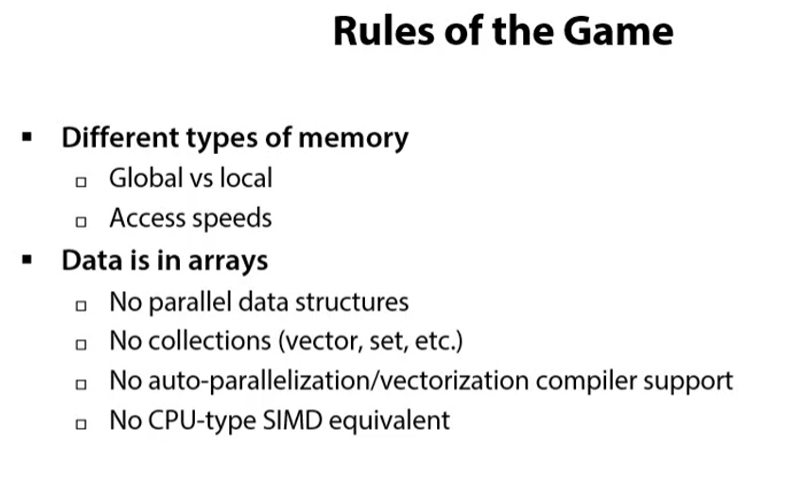

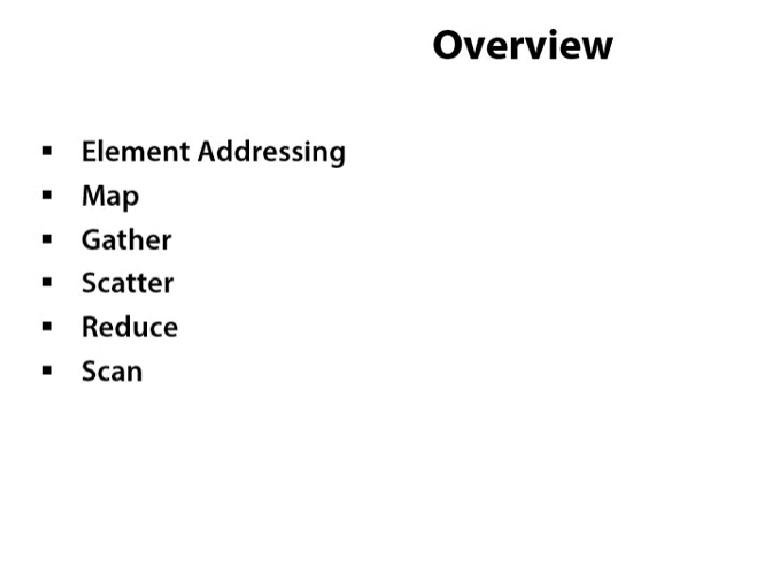

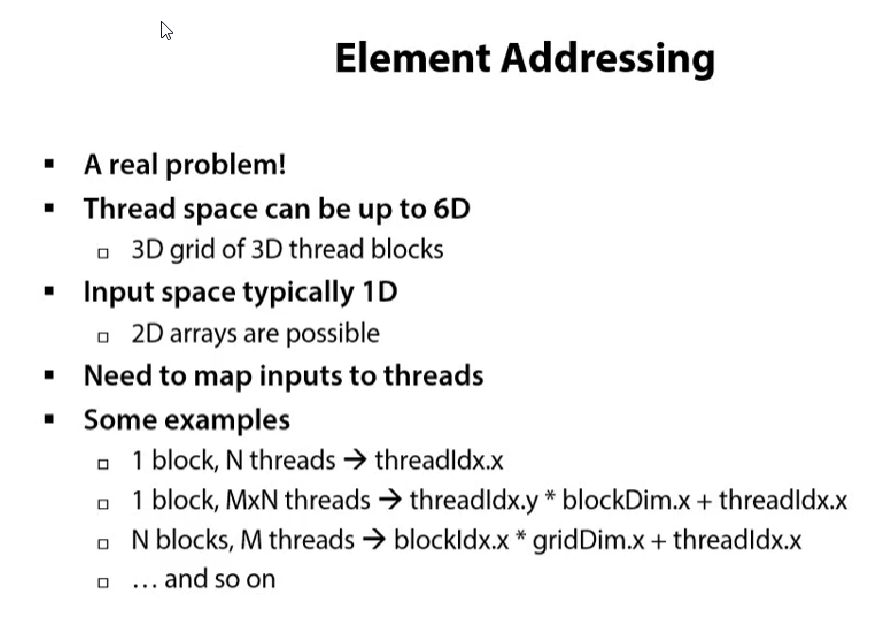

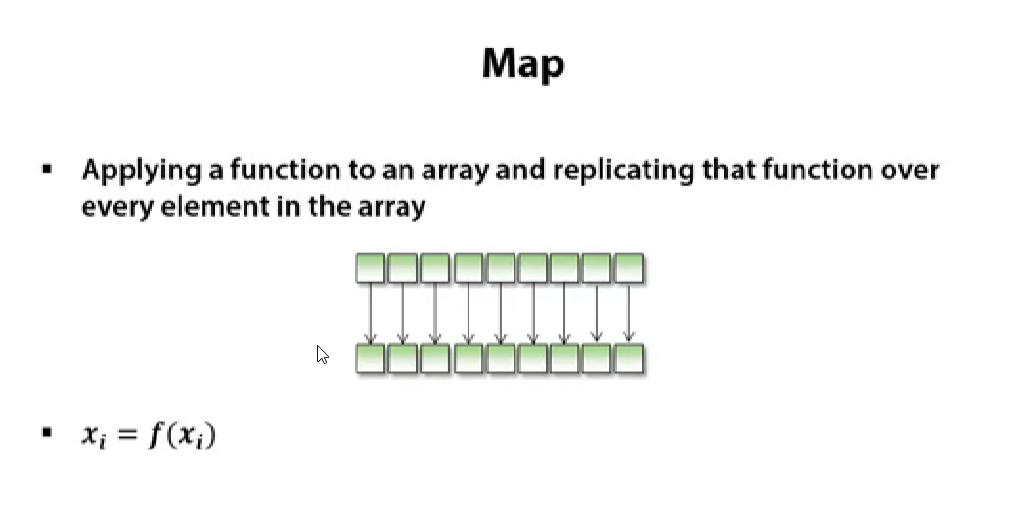

In [8]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "curand.h"

#include <iostream>
#include <ctime>
#include <cstdio>
#include <cuda.h>
#include <curand_kernel.h>
#include <math.h>
using namespace std;

#define CUDA_CALL(x) do { if((x)!=cudaSuccess) { \
    printf("Error at %s:%d\n",__FILE__,__LINE__);\
    return EXIT_FAILURE;}} while(0)
#define CURAND_CALL(x) do { if((x)!=CURAND_STATUS_SUCCESS) { \
    printf("Error at %s:%d\n",__FILE__,__LINE__);\
    return EXIT_FAILURE;}} while(0)

__global__ void addTen(float* d, int count)
{
    int threadsPerBlock =  blockDim.x * blockDim.y * blockDim.z;
    int threadPosInBlock = threadIdx.x +
                           blockDim.x * threadIdx.y +
                           blockDim.x * blockDim.y * threadIdx.z;
     int blockPosInGrid = blockIdx.x +
                           gridDim.x * blockIdx.y +
                           gridDim.x * gridDim.y * blockIdx.z;
     int tid = blockPosInGrid * threadsPerBlock + threadPosInBlock;
     if(tid < count)
     {
         d[tid] =  d[tid]+10;
     }
}

int main()
{
    
    curandGenerator_t gen;
    curandCreateGenerator(&gen, CURAND_RNG_PSEUDO_MTGP32);
    curandSetPseudoRandomGeneratorSeed(gen, time(0));
 
    const int count = 123456;
    const int size = count* sizeof(float);
    float *d;
    float h[count];
    cudaMalloc(&d, size);
    curandGenerateUniform(gen, d, count);
 
    dim3 block(8,8,8);
    dim3 grid(16,16);
    
    addTen<<<grid,block>>>(d,count);
 
    cudaMemcpy(h,d,size,cudaMemcpyDeviceToHost);
    cudaFree(d);
 
    for (int i = 0; i < 100; i++)
    {
        cout << h[i] << endl;
    }
  
     getchar();
    
    return 0;
}

/usr/bin/ld: /tmp/tmpxft_0000b388_00000000-11_73ae7e25-9cc2-4b18-9d93-42638e7b20a8.o: in function `main':
tmpxft_0000b388_00000000-6_73ae7e25-9cc2-4b18-9d93-42638e7b20a8.cudafe1.cpp:(.text+0x61): undefined reference to `curandCreateGenerator'
/usr/bin/ld: tmpxft_0000b388_00000000-6_73ae7e25-9cc2-4b18-9d93-42638e7b20a8.cudafe1.cpp:(.text+0x80): undefined reference to `curandSetPseudoRandomGeneratorSeed'
/usr/bin/ld: tmpxft_0000b388_00000000-6_73ae7e25-9cc2-4b18-9d93-42638e7b20a8.cudafe1.cpp:(.text+0xc6): undefined reference to `curandGenerateUniform'
collect2: error: ld returned 1 exit status



Gather

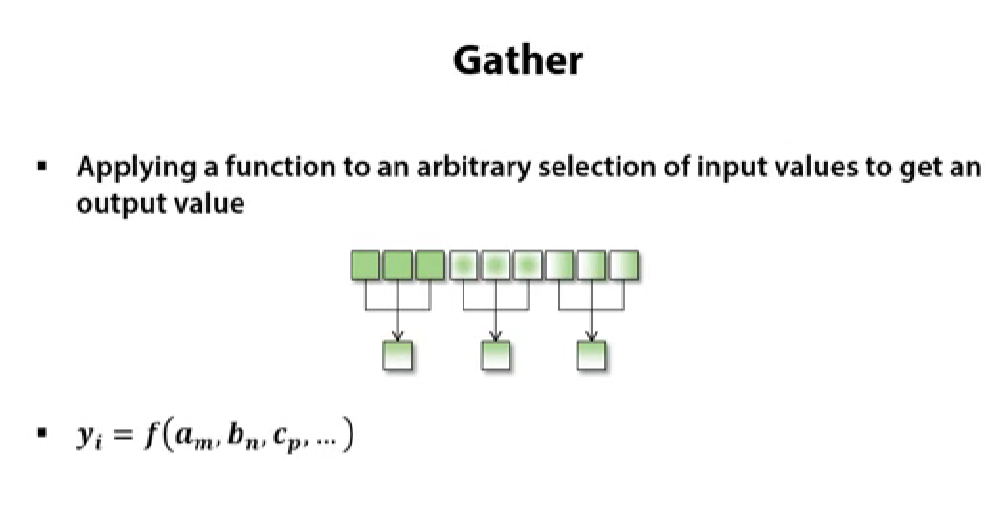

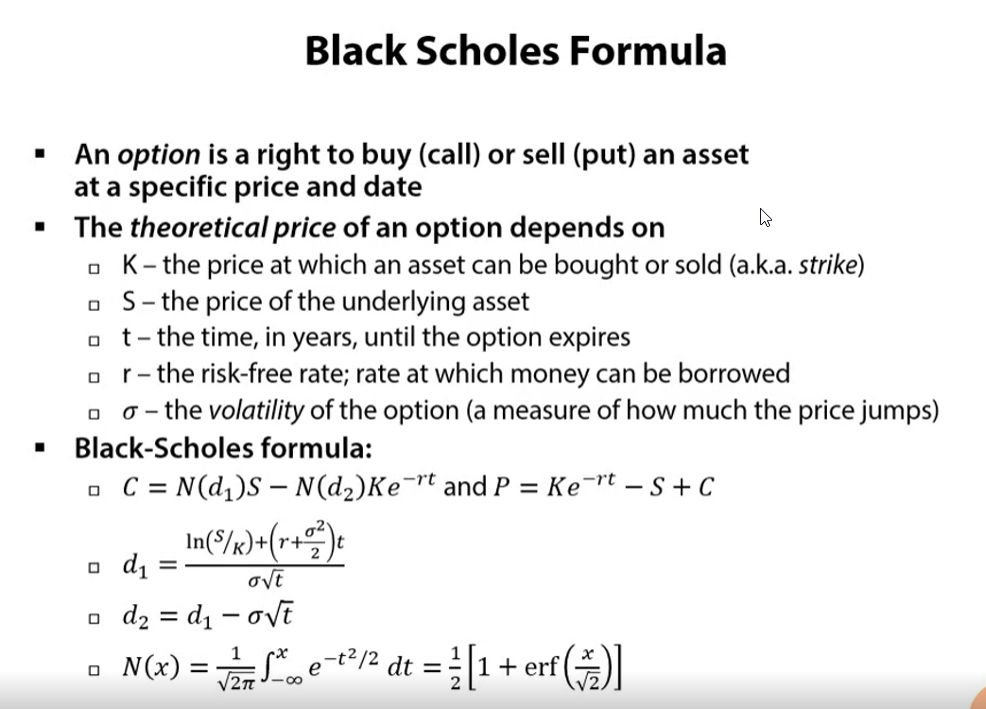

In [9]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "curand.h"

#define _USE_MATH_DEFINES
#include <iostream>
#include <ctime>
#include <cstdio>
#include <math.h>
using namespace std;

__device__ __host__ __inline__ float N(2float x)
{
    return (0.5 + 0.5 * erf(x * M_SQRT1_2));
}


__device__ __host__ void price(float k, float* s, float* t, float*r, float* v
                      float* c, float* p)
{
    float srt = v* sqrt(t);
    float d1 = (logf(s/k)+r+0.5*v*v)/srt;
    float d2 = d1 - srt;
    float kert = k*expf(-r*t);
    *c = N(d1)*s - N(d2)*kert;
    *p = kert - s + *c;
}


__global__ void price(float*k, float* s, float* t, float*r, float* v
                      float* c, float* p)
{
    int idx = threadIdx.x;
    price(k[idx], s[idx], t[idx], r[idx], v[idx], &c[idx], &p[idx]);
}


int main()
{
    const int count = 512;
    const int size = count * sizeof(float);
    float *args[5];
 
    curandGenerator_t gen;
    curandCreateGenerator(&gen, CURAND_RNG_PSEUDO_MTGP32);
    
    for(int i =0; i<5; i++)
    {
        cudaMalloc(&args[i], size);
        curandGenerateUniform(gen, args[i], count);
    }
 
    float *dc, *dp;
    cudaMalloc(&dc, size);
    cudaMalloc(&dp, size);
 
    price<<<1,count>>>(args[0], args[1], args[2], args[3],args[4], dc, dp);
    
  
    return 0;
}

/tmp/tmp9idvlx20/82061346-b33f-455f-9c63-c95da53d3c8c.cu(12): warning: a user-provided literal suffix must begin with "_"

/tmp/tmp9idvlx20/82061346-b33f-455f-9c63-c95da53d3c8c.cu(12): warning: inline variables are a C++17 feature

/tmp/tmp9idvlx20/82061346-b33f-455f-9c63-c95da53d3c8c.cu(12): warning: attribute "__host__" does not apply here

/tmp/tmp9idvlx20/82061346-b33f-455f-9c63-c95da53d3c8c.cu(12): error: An inline __device__/__constant__/__managed__ variable must have internal linkage when the program is compiled in whole program mode (-rdc=false)

/tmp/tmp9idvlx20/82061346-b33f-455f-9c63-c95da53d3c8c.cu(12): error: user-defined literal operator not found

/tmp/tmp9idvlx20/82061346-b33f-455f-9c63-c95da53d3c8c.cu(12): error: expected a ")"

/tmp/tmp9idvlx20/82061346-b33f-455f-9c63-c95da53d3c8c.cu(13): error: expected a ";"

/tmp/tmp9idvlx20/82061346-b33f-455f-9c63-c95da53d3c8c.cu(60): warning: parsing restarts here after previous syntax error

/tmp/tmp9idvlx20/82061346-b33f-455f-9

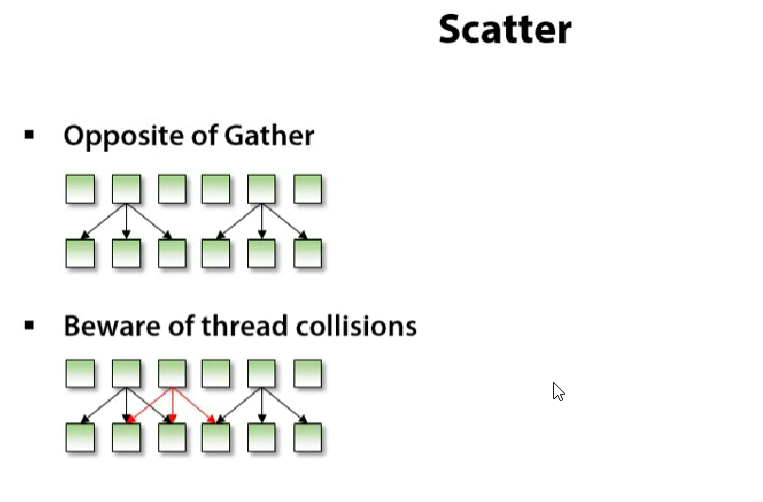

Reduce

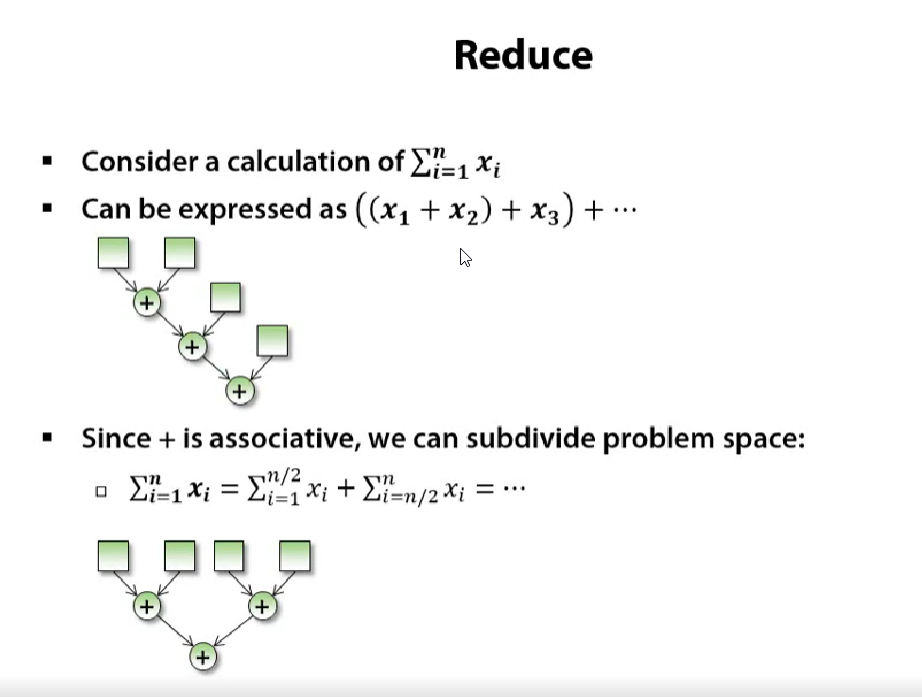

Reduce in Practice

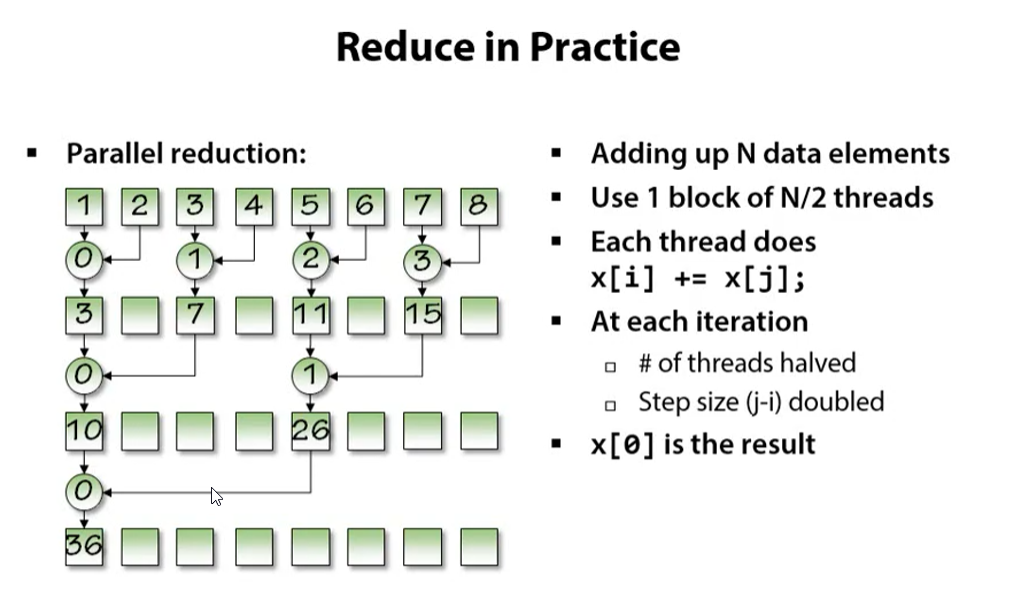

In [10]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <iostream>
using namespace std;

__global__ void sumSingleBlock(int* d)
{
    int tid = threadIdx.x;
    #// tc-- number of participating threads
    for(int tc = blockDim.x, stepSize =1; tc > 0; tc >>= 1, stepSize <<=1)
    {
        #// thread must be allowed to write
        if(tid < tc)
        {
            int pa = tid * stepSize * 2;
            int pb = pa + stepSize;
            d[pa] += d[pb];
        }
    } 
    
}


int main()
{
   const int count = 512;
   const int size = count*sizeof(int);

   int h[count];
   for(int i = 0; i < count; ++i)
   {
       h[i] = i+1;
   } 
 
  int *d;
 
  cudaMalloc(&d, size);
  cudaMemcpy(d,h,size,cudaMemcpyHostToDevice);
 
  sumSingleBlock<<<1,count/2>>>(d);
  int result;
  cudaMemcpy(&result,d,sizeof(int), cudaMemcpyDeviceToHost);
  cout<< "sum is " << result << endl;
 
  cudaFree(d);
  getchar();

    return 0;
}


sum is 131328



Scan

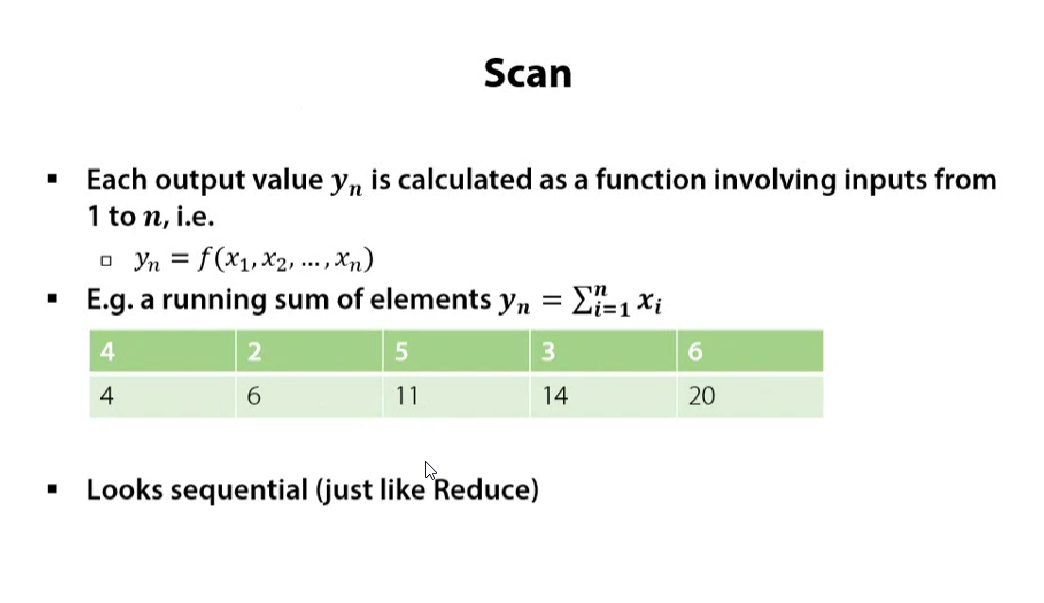


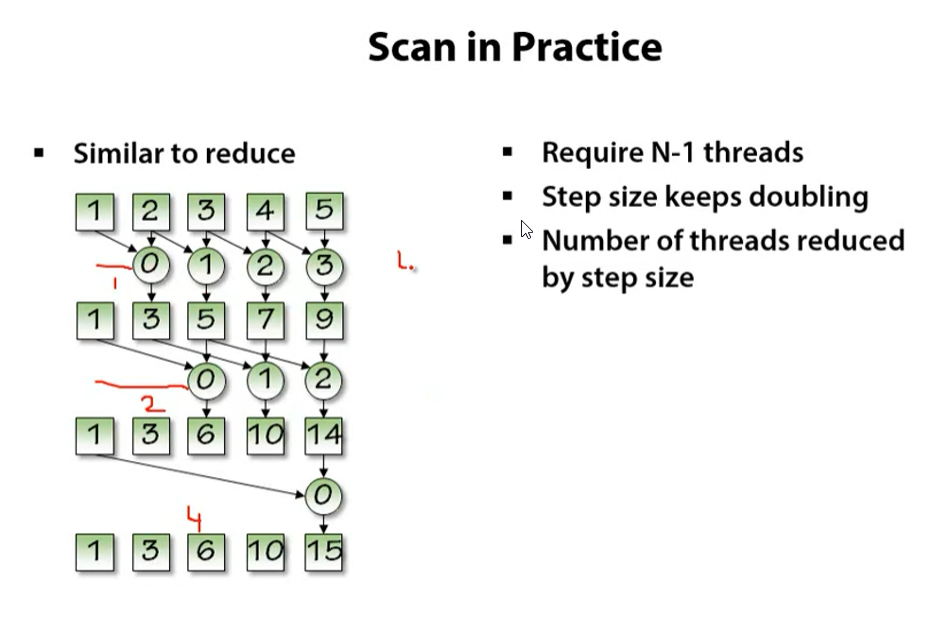


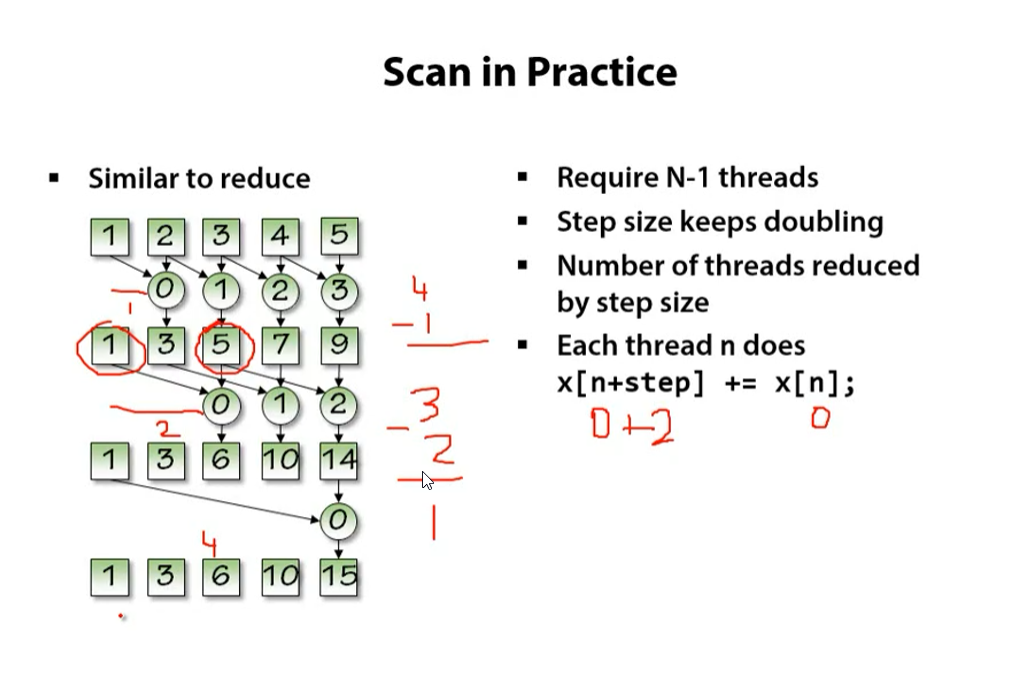

In [11]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <iostream>
using namespace std;

__global__ void runningSum(int* d)
{
    int threads = blockDim.x;
    int tid = threadIdx.x;
 
    #// tc -total number of threads allowed
    for(int tc = threads, step =1; tc>0; step *= 2)
    {
        #// check if thread is allowed to do things
        if(tid < tc)
        {
            d[tid+step] += d[tid];
         
        }
      tc -= step;
    }
}

int main()
{
    
    const int count =16;
    const int size =  count * sizeof(int);
 
    int h[count];
   for(int i = 0; i< count; i++)
   {
       h[i] = i+1;
   }
    
    int *d;
   cudaMalloc(&d, size);
   cudaMemcpy(d,h,size,cudaMemcpyHostToDevice);
  
  runningSum<<<1,count-1>>>(d);
  cudaMemcpy(h,d,size,cudaMemcpyDeviceToHost);
    for(int i=0; i<count; i++)
     {
         cout << h[i] << '\t';
     }
 
 cudaFree(d);
 getchar();

    return 0;
 
}


1	3	6	10	15	21	28	36	45	55	66	78	91	105	120	136	


The Many Types of Memory 

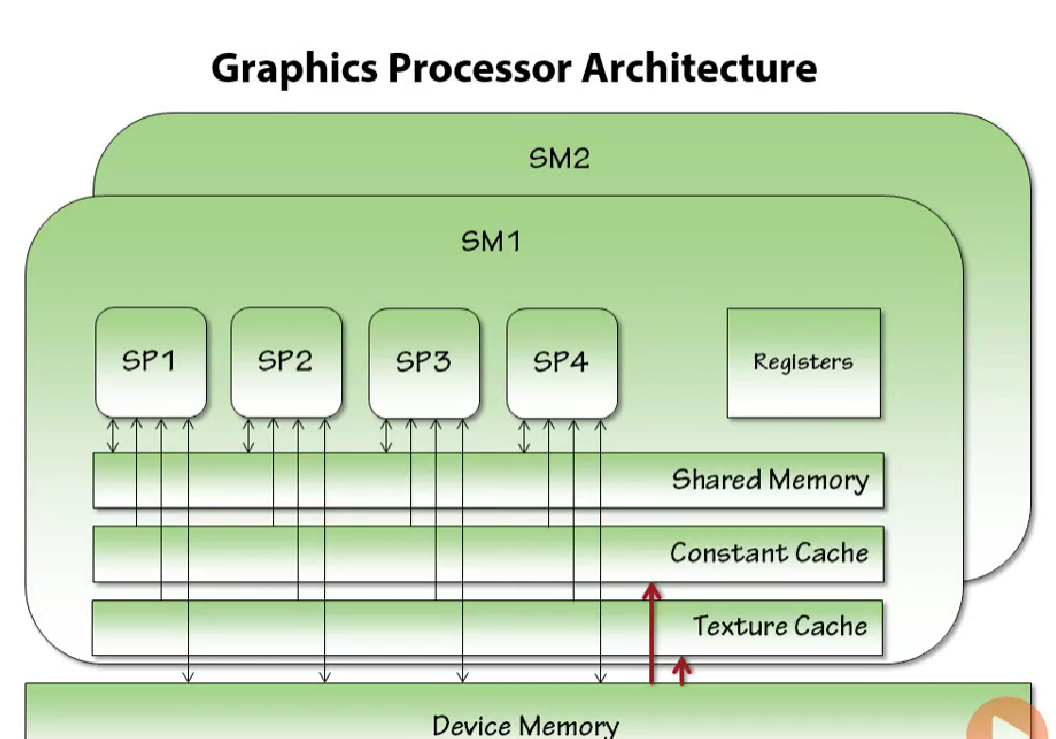




Device Memory

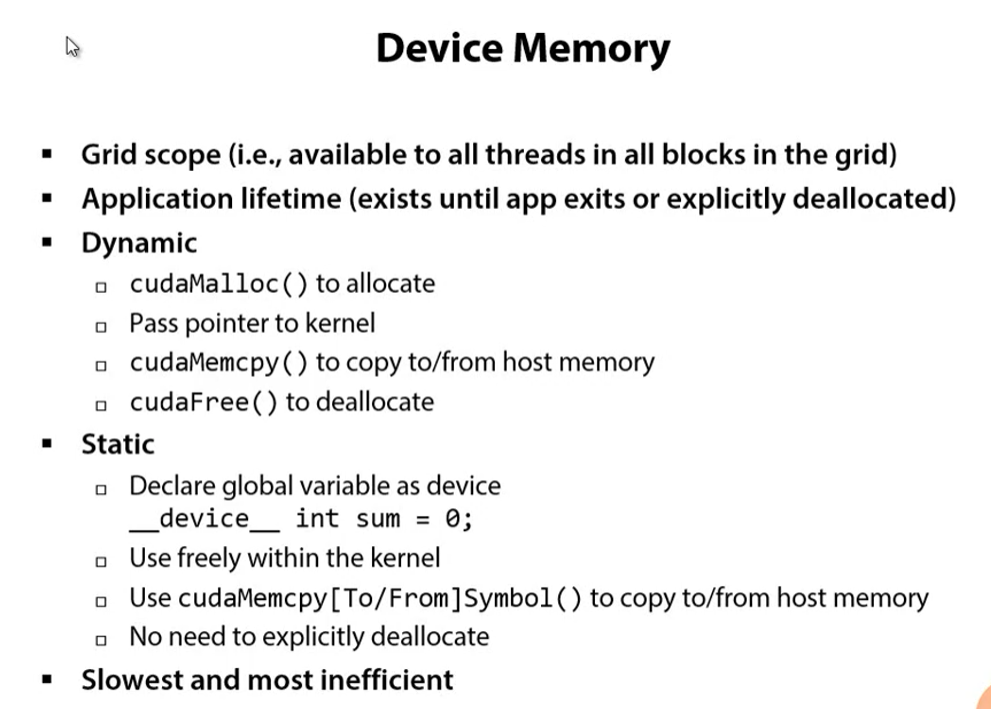

Constant & Texture Memory

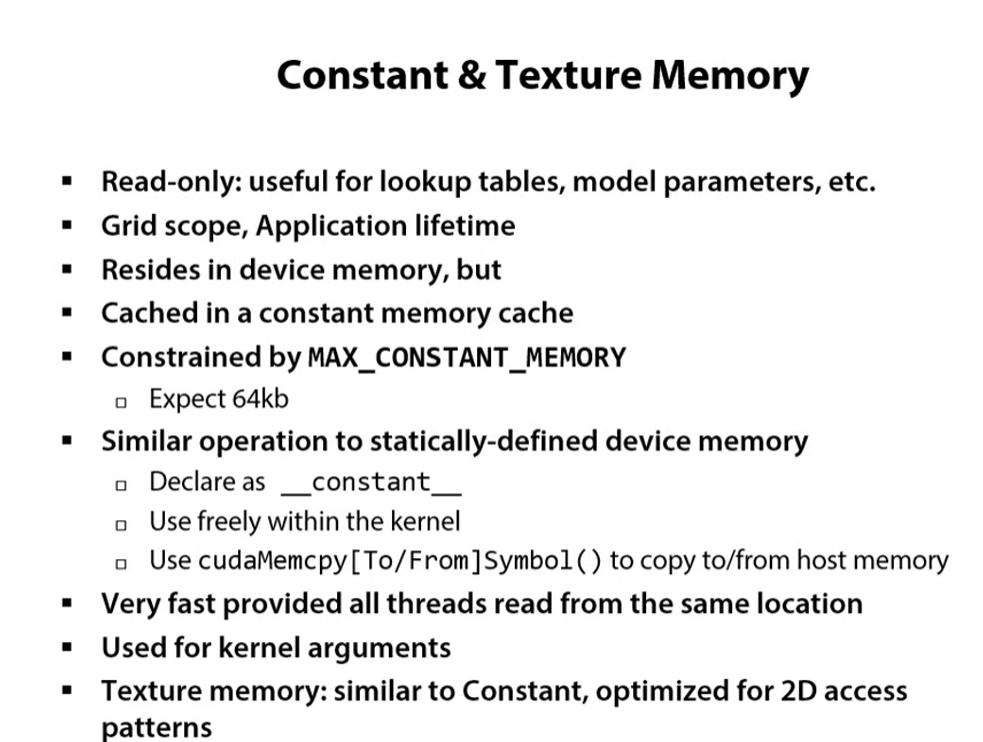

Shared Memory

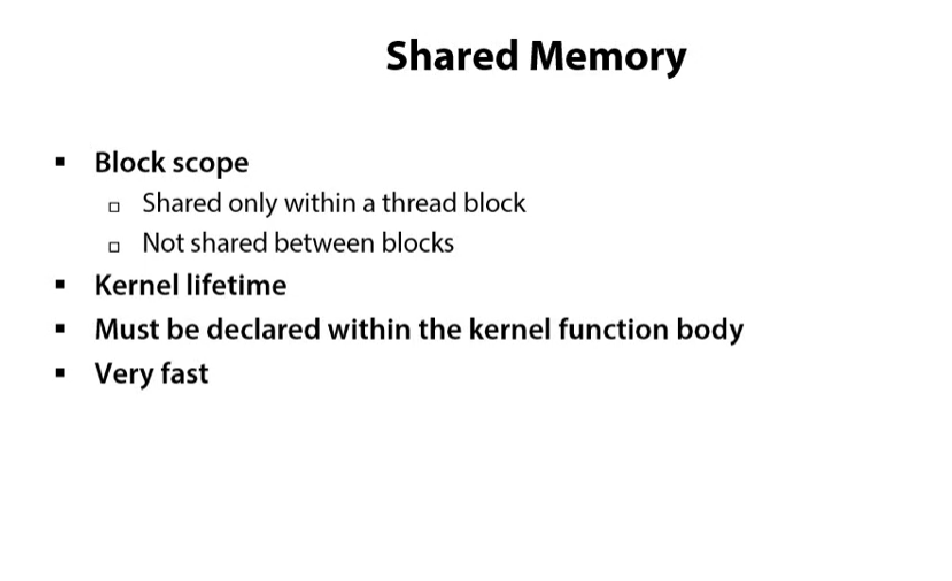

In [12]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <iostream>
using namespace std;

__global__ void sumSingleBlock(int* d)
{
    int tid = threadIdx.x;
    #// tc-- number of participating threads
    for(int tc = blockDim.x, stepSize =1; tc > 0; tc >>= 1, stepSize <<=1)
    {
        #// thread must be allowed to write
        if(tid < tc)
        {
            int pa = tid * stepSize * 2;
            int pb = pa + stepSize;
            d[pa] += d[pb];
        }
    } 
    
}
__global__ void sumSingleBlock2(int* d)
{
    extern __shared__ int dcopy[];
 
    int tid = threadIdx.x;
    dcopy[tid*2] = d[tid*2];
    dcopy [(tid*2)+1] = d[(tid*2)+1];
 
    #// tc-- number of participating threads
    for(int tc = blockDim.x, stepSize =1; tc > 0; tc >>= 1, stepSize <<=1)
    {
        #// thread must be allowed to write
        if(tid < tc)
        {
            int pa = tid * stepSize * 2;
            int pb = pa + stepSize;
            dcopy[pa] += dcopy[pb];
        }
    } 
      if(tid ==0)
      {
          d[0] = dcopy[0];
      }
}

int main()
{
   const int count = 32;
   const int size = count*sizeof(int);

   int h[count];
   for(int i = 0; i < count; ++i)
   {
       h[i] = i+1;
   } 
 
  int *d;
 
  cudaMalloc(&d, size);
  cudaMemcpy(d,h,size,cudaMemcpyHostToDevice);
 
  sumSingleBlock2<<<1,(count/2), size>>>(d);
  int result;
  cudaMemcpy(&result,d,sizeof(int), cudaMemcpyDeviceToHost);
  cout<< "sum is " << result << endl;
 
  cudaFree(d);
  getchar();

    return 0;
}

sum is 528



Register & Local Memory

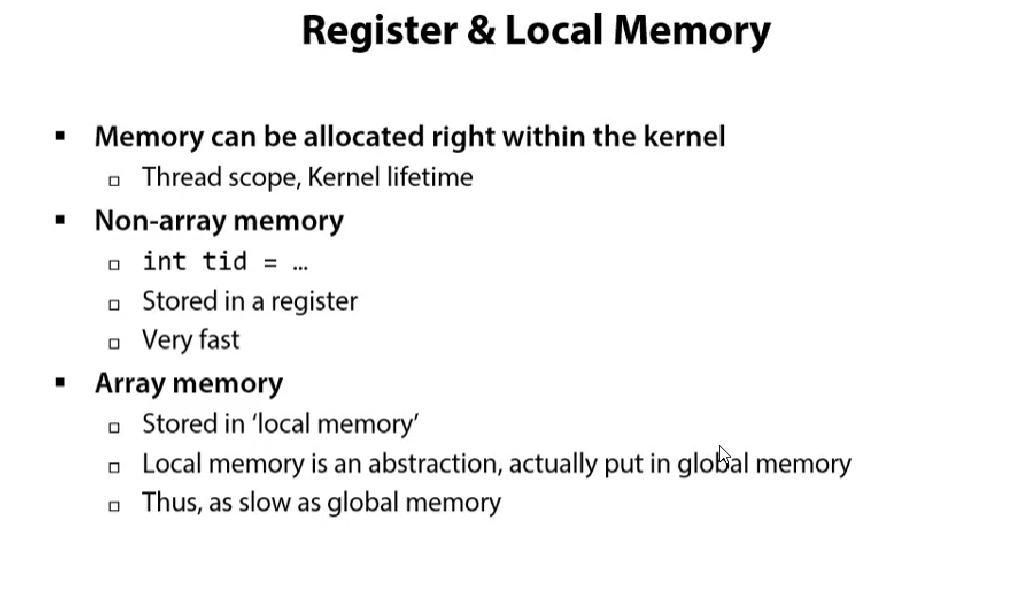

Summary

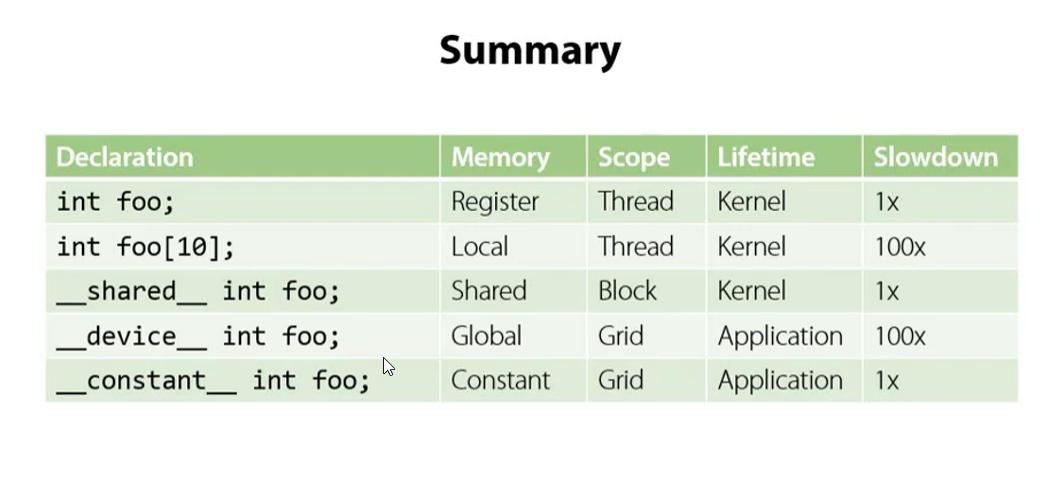

Thread Cooperation and Synchronization

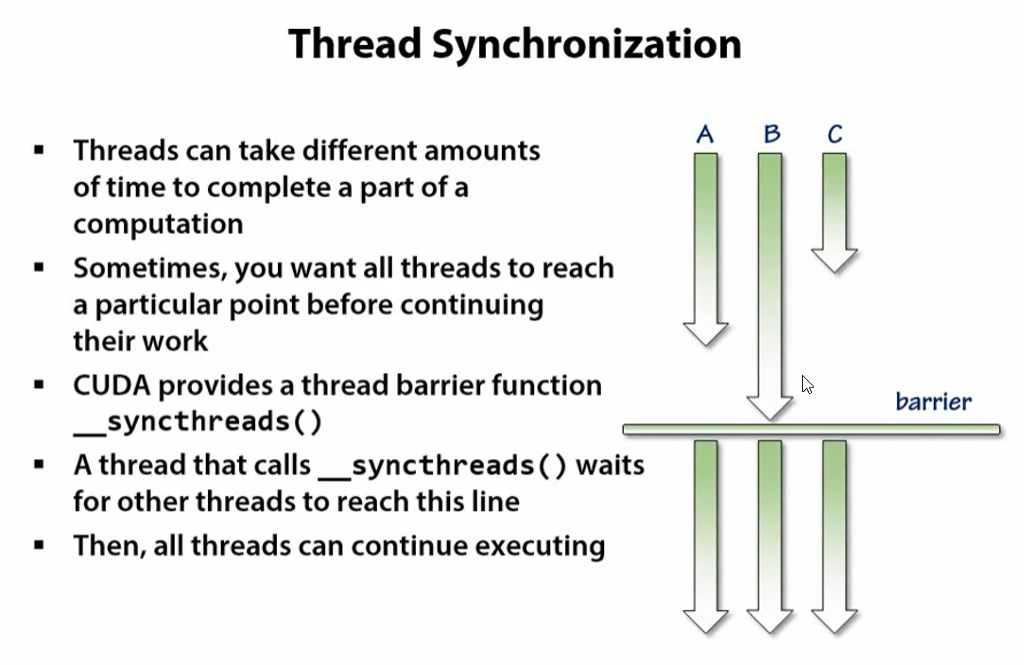

In [13]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#define _USE_MTH_DEFINES
#include <math.h>
#include <iostream>
using namespace std;

__global__ void kernel(unsigned char* src)
{
    __shared__ float temp[16][16];
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x+y*blockDim.x * gridDim.x;
 
    const float period = 128.0;
    temp[threadIdx.x][threadIdx.y]= 255 *
      (sinf(x*2.0f*M_PI/period)+ 1.0f)*
      (sinf(y*2.0f*M_PI/period)+ 1.0f) / 4.0f;
 
   __syncthreads();
   src[offset*4] = 0;
   src[offset*4+1] = temp[15-threadIdx.x][15-threadIdx.y];
   src[offset*4+2] = 0;
   src[offset*4+3] = 0;

}


extern "C" __declspec(dllexport) void GenerateBitmap( 
    unsigned char* dst, int dimension)
{
    int size =  dimension * dimension * 4;
 
    // allocate
   unsigned char* src;
   cudaMalloc(&src, size);
 
  dim blocks(dimension/16, dimension/16);
   dim3 threads(16,16);
 kernel<<<blocks, threads>>>(src);


 cudaMemcpy(dst,src,size.cudaMemcpyDeviceToHost);
 cudaFree(src);

}


int main()
{
    return 0;
}



/tmp/tmp8sfwi3vp/8bfcdec3-d492-4e86-b5ca-064f91280543.cu(30): error: explicit type is missing ("int" assumed)

/tmp/tmp8sfwi3vp/8bfcdec3-d492-4e86-b5ca-064f91280543.cu(30): error: identifier "dllexport" is undefined

/tmp/tmp8sfwi3vp/8bfcdec3-d492-4e86-b5ca-064f91280543.cu(30): error: expected a ";"

At end of source: warning: parsing restarts here after previous syntax error

3 errors detected in the compilation of "/tmp/tmp8sfwi3vp/8bfcdec3-d492-4e86-b5ca-064f91280543.cu".



Branch Divergence


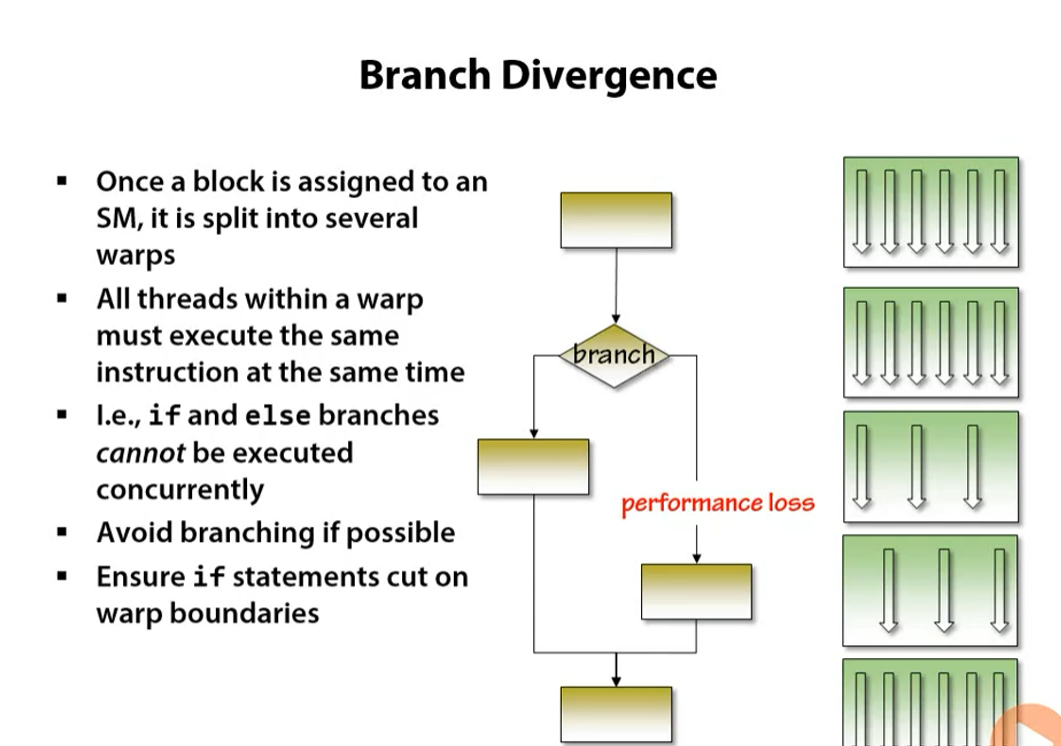

Summary

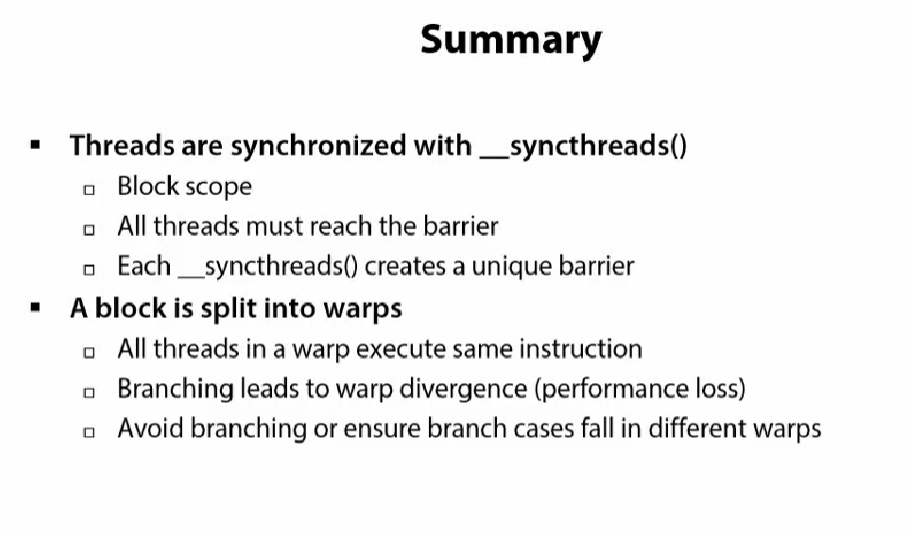

Atomic Operations

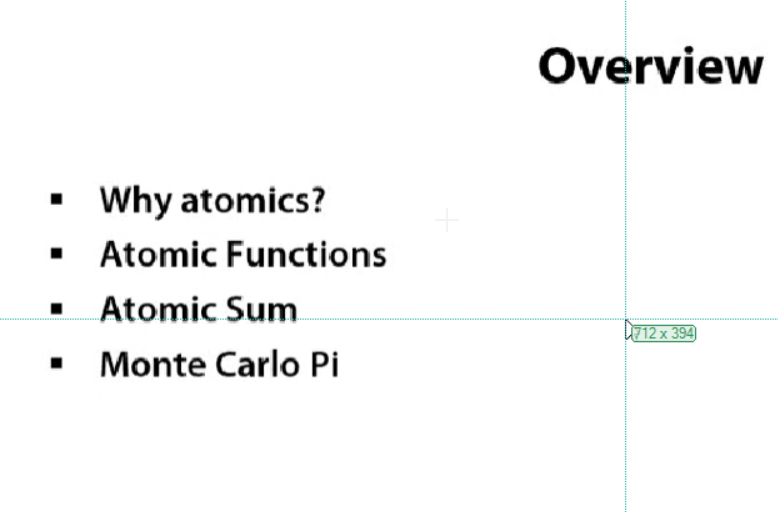



Why Atomics?

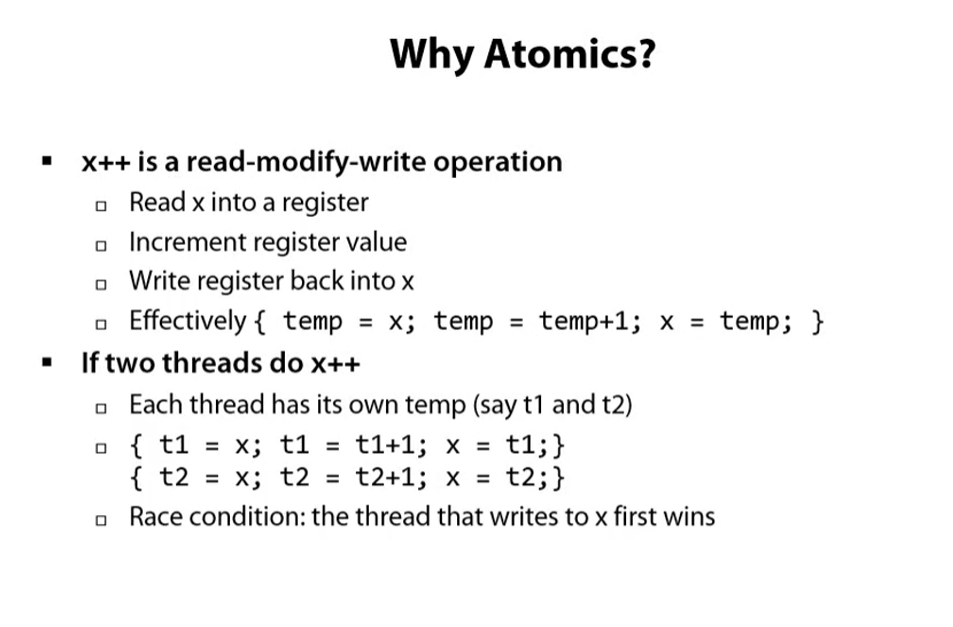

Atomic Functions

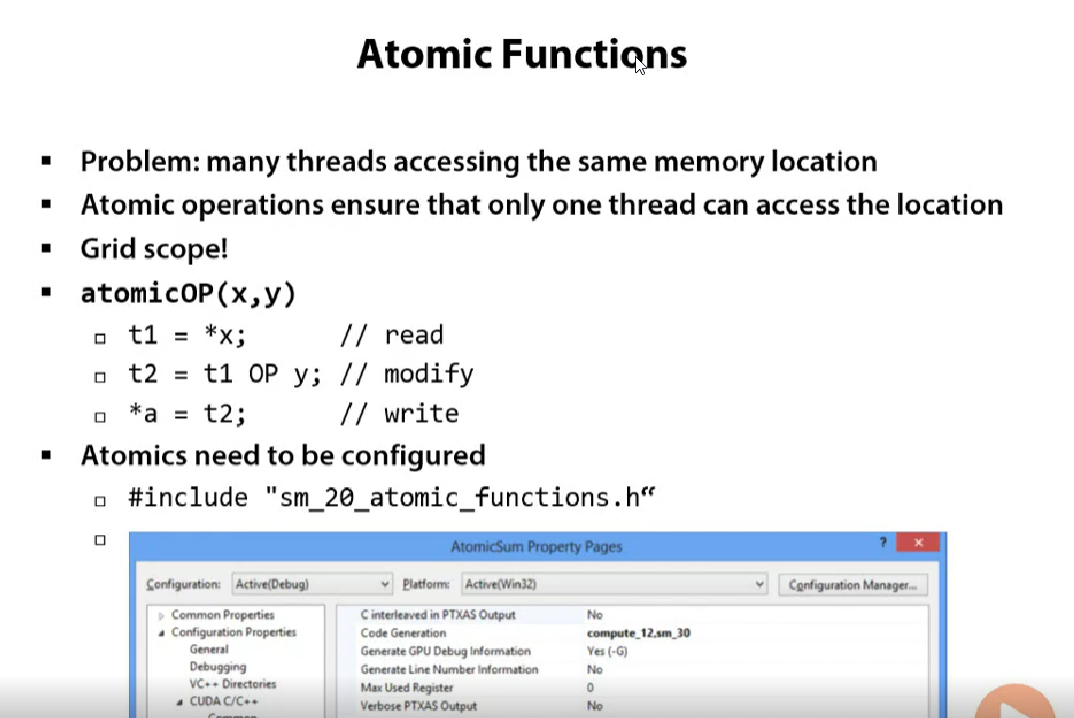

In [14]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "sm_20_atomic_functions.h"

#include <iostream>
using namespace std;

__device__ int dSum = 0;

__global__ void sum(int* d)
{
    int tid = threadIdx.x;
    #//dSum += d[tid];
   atomicAdd(&dSum, d[tid]);
}

int main()
{
    const int count = 128;
    const int size = sizeof(int)*count;
    
    int h[count];
    for(int i =0; i<count; i++)
    {
        h[i] = i+1;
    }
 
   int * d;
   cudaMalloc(&d, size);
   cudaMemcpy(d,h,size,cudaMemcpyHostToDevice);
   sum<<<1,count>>>(d);
 
   int hSum;
   cudaMemcpyFromSymbol(&hSum, dSum, sizeof(int));
   cout << "The sum of numbers from 1 to  " << count
       << " is " << hSum << endl;
 
   cudaFree(d);
   getchar();
   return 0;
 
}

The sum of numbers from 1 to  128 is 8256



Monte Carlo Pi

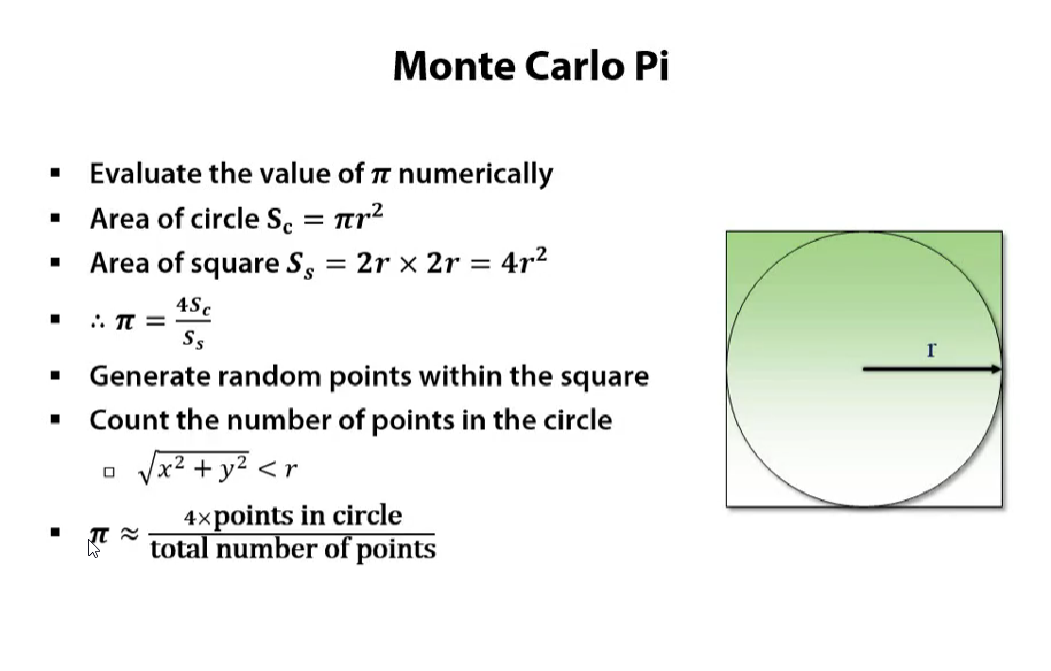



In [15]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "curand.h"

#include <iostream>
#include <iomanip>
using namespace std;

__device__ int dCount = 0;

__global__ void countPoints(const float* xs,
                            const float* ys)
{
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    float x = xs[idx] - 0.5f;
    float y = ys[idx] - 0.5f;
    int n = sqrtf(x*x+y*y) > 0.5f ? 0:1;
    atomicAdd(&dCount,n);
 

}

int main()
{
    const int count = 512*512;
    const int size = count * sizeof(float);
    cudaError_t cudaStatus;
    curandStatus_t curandStatus;
 curandGenerator_t gen;

 curandStatus = curandCreateGenerator(&gen, CURAND_RNG_PSEDUO_MTGP32);
 curandSetPseudoRandomGneratorSeed(gen, time(0));


 float* x;
 float* y;
 cudaStatus = cudaMalloc(&x, size);
 cudaSttaus = cudaMalloc(&y, size);

 curandStatus = curandGenerateUniform(gen, x, count);
 curandStatus = curandGenerateUniform(gen, x, count);

 countPoints<<<512, 512>>>(x,y);

 int hCount;
 cudaMemcpyFromSymbol(&hCount, dCount, sizeof(int));

 cudaFree(x);
 cudaFree(y);

 cout<< setprecision(12) 
 << "pi is approximately "
 << (4.0f * (float)hcount / (float)count)
 << endl;

getchar();
 return 0;

}


/tmp/tmpaap8b0uu/331c66bd-4e07-4788-822d-37f31a64a2da.cu(31): error: identifier "CURAND_RNG_PSEDUO_MTGP32" is undefined

/tmp/tmpaap8b0uu/331c66bd-4e07-4788-822d-37f31a64a2da.cu(32): error: identifier "curandSetPseudoRandomGneratorSeed" is undefined

/tmp/tmpaap8b0uu/331c66bd-4e07-4788-822d-37f31a64a2da.cu(38): error: identifier "cudaSttaus" is undefined

/tmp/tmpaap8b0uu/331c66bd-4e07-4788-822d-37f31a64a2da.cu(53): error: identifier "hcount" is undefined

/tmp/tmpaap8b0uu/331c66bd-4e07-4788-822d-37f31a64a2da.cu(27): warning: variable "cudaStatus" was set but never used

/tmp/tmpaap8b0uu/331c66bd-4e07-4788-822d-37f31a64a2da.cu(28): warning: variable "curandStatus" was set but never used

4 errors detected in the compilation of "/tmp/tmpaap8b0uu/331c66bd-4e07-4788-822d-37f31a64a2da.cu".



Summary

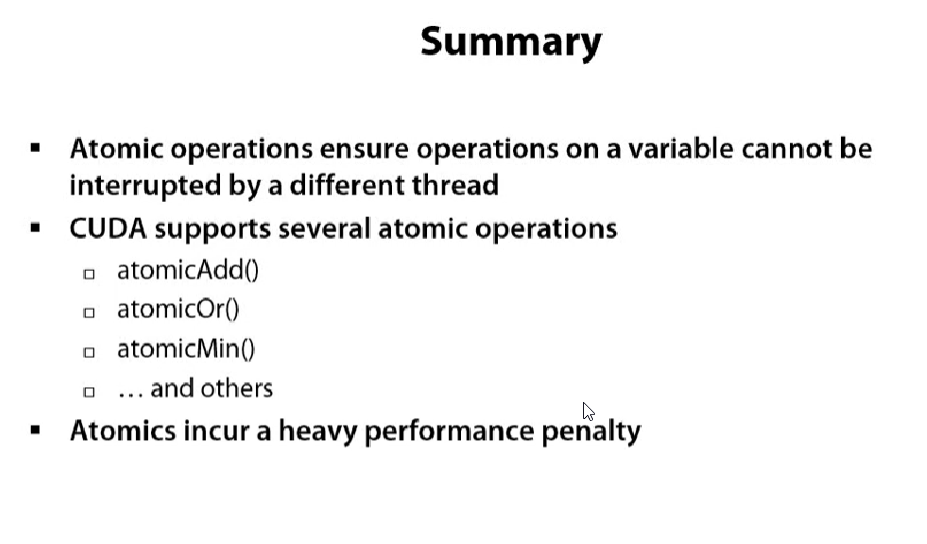

Events & Streams

Overview

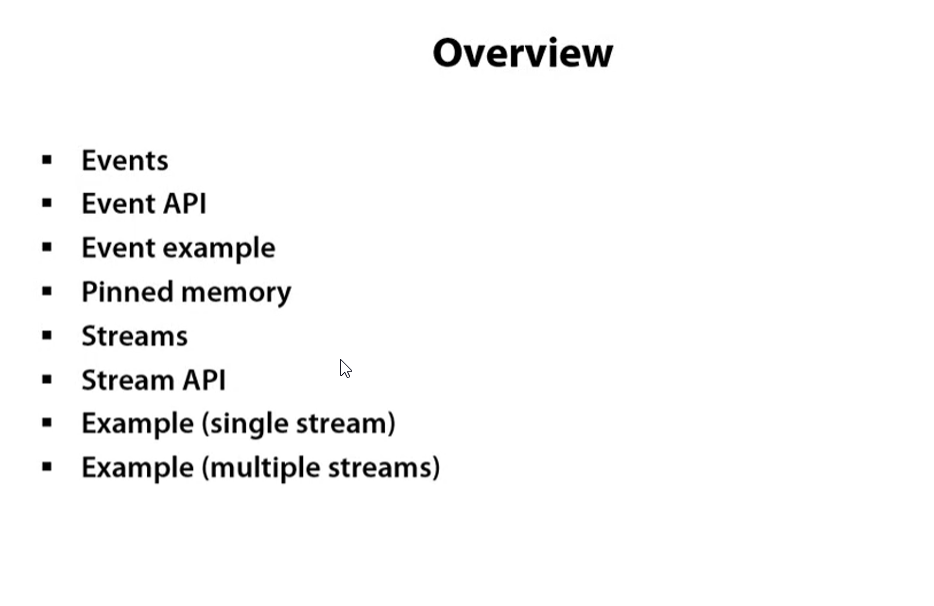



EVENTS

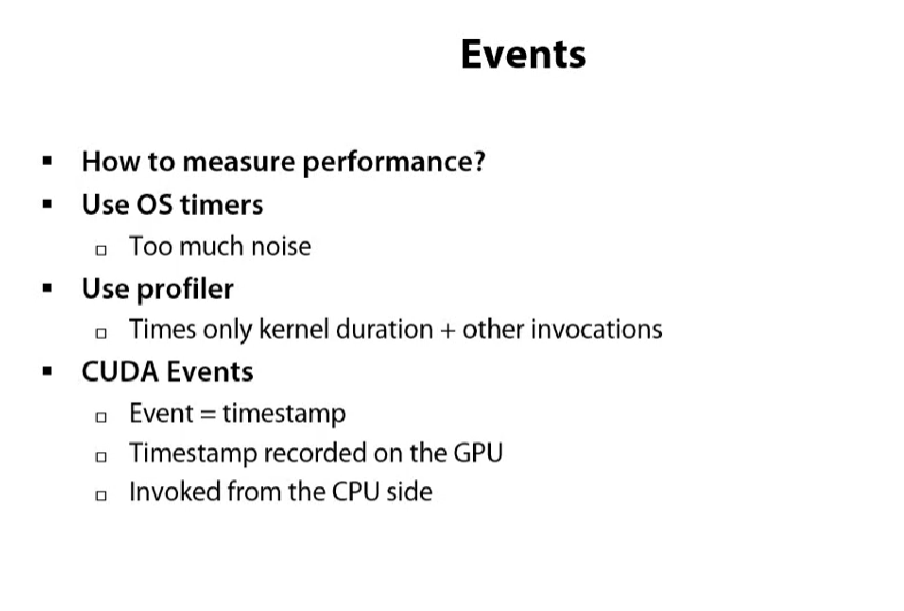

Event API


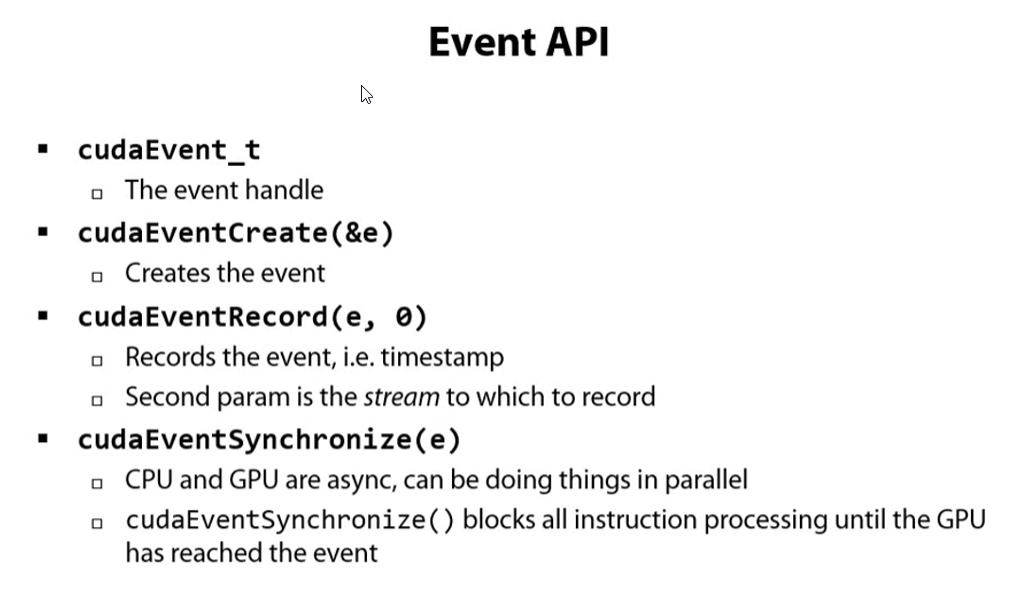

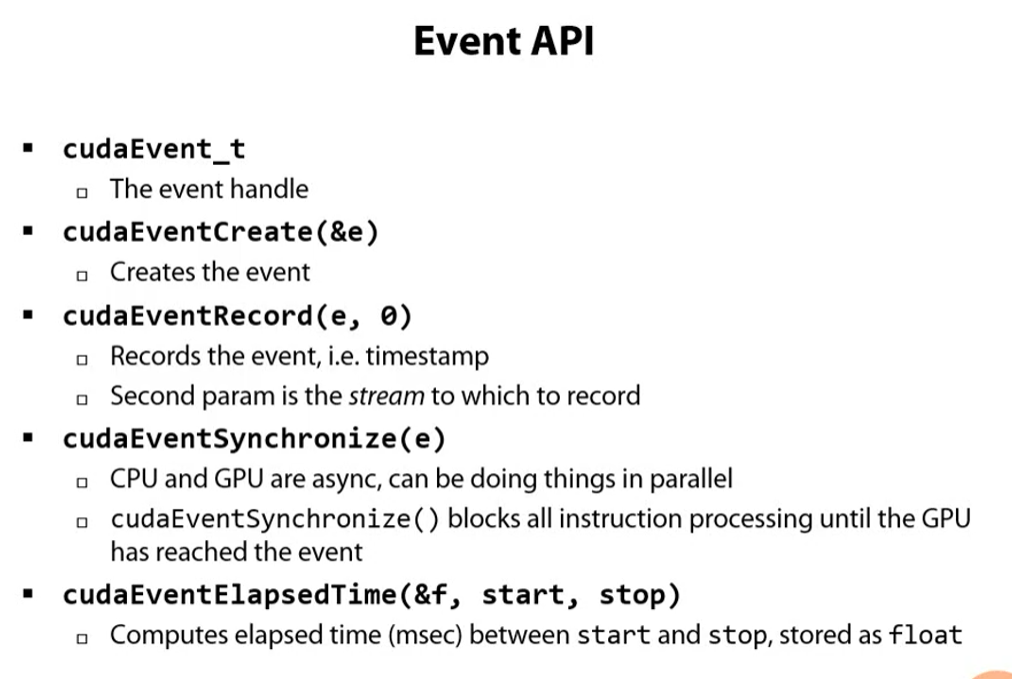

In [16]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include "sm_20_atomic_functions.h"

#include <iostream>
using namespace std;

__device__ int dSum = 0;

__global__ void sum(int* d)
{
    int tid = threadIdx.x;
    #//dSum += d[tid];
   atomicAdd(&dSum, d[tid]);
}

int main()
{
    const int count = 128;
    const int size = sizeof(int)*count;
    
    int h[count];
    for(int i =0; i<count; i++)
    {
        h[i] = i+1;
    }
 
   int * d;
   cudaMalloc(&d, size);
   cudaMemcpy(d,h,size,cudaMemcpyHostToDevice);

 cudaEvent_t start, end;
 cudaEventCreate(&start);
 cudaEventCreate(&end);

 cudaEventRecord(start);
   sum<<<1,count>>>(d);
 cudaEventRecord(end);
 cudaEventSynchronize(end);

 float elapsed;
 cudaEventElapsedTime(&elapsed, start, end);
   int hSum;
   cudaMemcpyFromSymbol(&hSum, dSum, sizeof(int));
   cout << "The sum of numbers from 1 to  " << count
       << " is " << hSum << "  and it took " << elapsed
       <<  " msec" << endl;
 
   cudaFree(d);
  cudaDeviceReset();
   #//getchar();
   return 0;
 
}

The sum of numbers from 1 to  128 is 8256  and it took 0.020192 msec



Pinned Memory

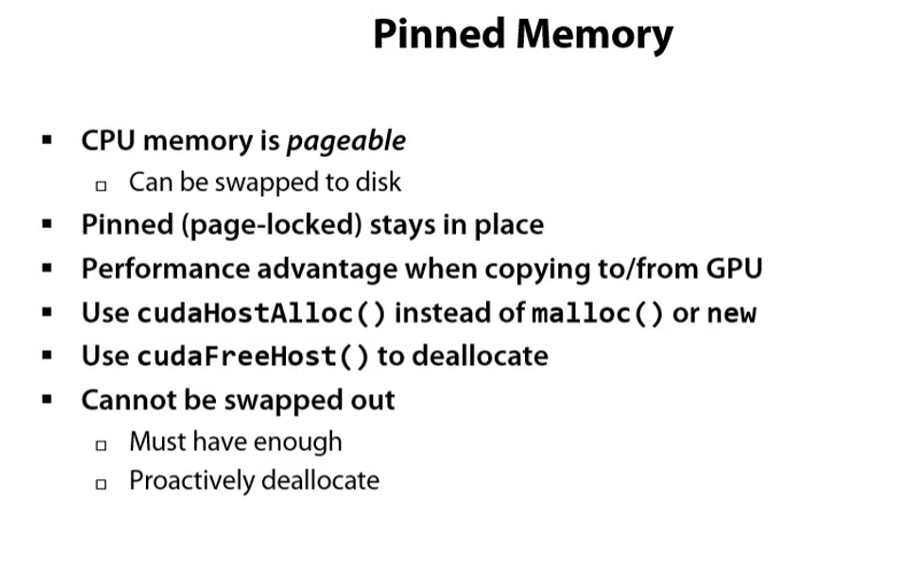

In [17]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <iostream>
using namespace std;

float timeMemory(bool pinned, bool toDevice)
{
    const int count = 1<<20;
    const int iterations = 1<<6;
 const int size = count * sizeof(int);

 cudaEvent_t start, end;
 int *h, *d;
 float elapsed;
 cudaError_t status;

 cudaEventCreate(&start);
 cudaEventCreate(&end);

 cudaMalloc(&d, size);
 if(pinned)
{
    cudaHostAlloc(&h, size, cudaHostAllocDefault);
}
 else
 {
     h = new int[count];
 }

cudaEventRecord(start);
 
 for(int i = 0; i<iterations; i++)
 {
     if(todevice)
     {
         status = cudaMemcpy(d,h,size,cudaMemcpyHostToDevice);
     }
   else
  {
       status = cudaMemcpy(d,h,size,cudaMemcpyDeviceToHost);
  }

  cudaEventRecord(end);
  cudaEventSynchronize(end);
  cudaEventElapsedTime(&elapsed, start, end);

  if(pinned)
  {
      cudaFreeHost(h);
  }
 else
  {
      delete [] h;
  }

cudaFree(d);
cudaEventDestroy(start);
cudaEventDestroy(end);
 }
return elapsed;

}
 
 int main()
 { 
  cout << "From device , paged memory: \t" << timeMemory(false,false) << endl;
  cout << "To device , paged memory: \t" << timeMemory(false, true) << endl;
  cout << "From device , pinned memory: \t" << timeMemory(true,false) << endl;
  cout << "To device , pinned memory: \t" << timeMemory(true,true) << endl;
   
   getchar();
  return 0;


 }


/tmp/tmphvfphszr/d11a0f00-3824-47b0-9e6c-ec14ac079c07.cu(34): error: identifier "todevice" is undefined

/tmp/tmphvfphszr/d11a0f00-3824-47b0-9e6c-ec14ac079c07.cu(15): warning: variable "status" was set but never used

1 error detected in the compilation of "/tmp/tmphvfphszr/d11a0f00-3824-47b0-9e6c-ec14ac079c07.cu".



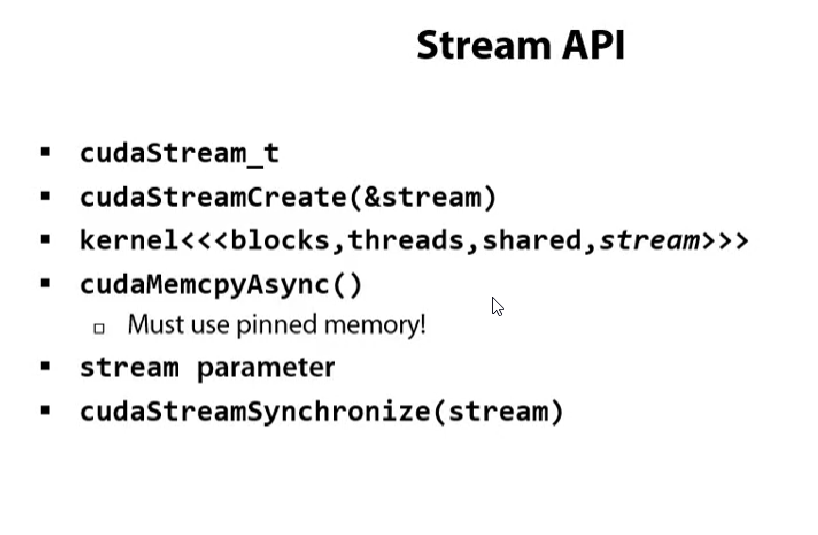

In [18]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <iostream>
#include <cmath>
#include <ctime>
using namespace std;

const int chunkCount = 1<<20;
const int totalCount = chunkCount << 3;


__global__ void kernel(float* a, float* b, float* c)
{
    int tid = blockDim.x*blockIdx.x + threadIdx.x;
    if(tid < chunkCount)
    {
         c[tid] = erff(a[tid]+b[tid]);
    }
 
}

int main()
{
    
 cudaDeviceProp prop;
 int device;
 cudaGetDevice(&device);
 cudaGetDeviceProperties(&prop, device);
 if(!prop.deviceOverlap)
 {
     return 0;
 }

}

In [ ]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <iostream>
#include <cmath>
#include <ctime>
using namespace std;

const int chunkCount = 1<<20;
const int totalCount = chunkCount << 3;


__global__ void kernel(float* a, float* b, float* c)
{
    int tid = blockDim.x*blockIdx.x + threadIdx.x;
    if(tid < chunkCount)
    {
         c[tid] = erff(a[tid]+b[tid]);
    }
 
}

int main()
{
    
 cudaEvent_t start, end;
 cudaEventCreate(&start);
 cudaEventCreate(&end);

 cudaStream_t stream;
 cudaStreamCreate(&stream);

 float *ha, *hb, *hc, *da, *db, *dc;
 const int totalSize = totalCount * sizeof(float);
 const int chunkSize = chunkCount * sizeof(float);

  #// Allocate Memory
 cudaMalloc(&da, chunkSize);
 cudaMalloc(&db, chunkSize);
 cudaMalloc(&dc, chunkSize);
 cudaHostAlloc(&ha, totalSize, cudaHostAllocDefault);
 cudaHostAlloc(&hb, totalSize, cudaHostAllocDefault);
 cudaHostAlloc(&hc, totalSize, cudaHostAllocDefault);

#// fill a and b
 
 srand((unsigned)time(0));
 for(int i = 0; i < totalCount; i++)
 {
     ha[i] = rand() / RAND_MAX;
     hb[i] = rand() / RAND_MAX;
  
 }

 cudaEventRecord(start, stream);

 for(int i = 0; i < totalCount; i++)
 {
     cudaMemcpyAsync(da, ha+i, chunkSize, cudaMemcpyHostToDevice,stream);
  cudaMemcpyAsync(da, ha+i, chunkSize, cudaMemcpyHostToDevice),stream;
  kernel<<<chunkCount/64,64,0,stream>>>(da, db, dc);
  cudaMemcpyAsync(hc+i, dc, chunkSize, cudaMemcpyDeviceToHost, stream);

 }


 cudaStreamSynchronize(stream);
 cudaEventRecord(end, stream);
 cudaEventSynchronize(end);

 float elapsed;
 cudaEventElapsedTime(&elapsed, start, end);

 cout << "This took " << elapsed << " msec " << endl;

 cudaFreeHost(ha);
 cudaFreeHost(hb);
 cudaFreeHost(hc);
 cudaFree(da);
 cudaFree(db);
 cudaFree(dc);

cudaStreamDestroy(stream);

getchar();
 
}

In [ ]:
%%cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <iostream>
#include <cmath>
#include <ctime>
using namespace std;

const int chunkCount = 1<<20;
const int totalCount = chunkCount << 3;


__global__ void kernel(float* a, float* b, float* c)
{
    int tid = blockDim.x*blockIdx.x + threadIdx.x;
    if(tid < chunkCount)
    {
         c[tid] = erff(a[tid]+b[tid]);
    }
 
}

int main()
{
    
 cudaEvent_t start, end;
 cudaEventCreate(&start);
 cudaEventCreate(&end);

 cudaStream_t stream;
 cudaStreamCreate(&stream);

 float *ha, *hb, *hc, *da, *db, *dc;
 const int totalSize = totalCount * sizeof(float);
 const int chunkSize = chunkCount * sizeof(float);

  #// Allocate Memory
 cudaMalloc(&da, chunkSize);
 cudaMalloc(&db, chunkSize);
 cudaMalloc(&dc, chunkSize);
 cudaHostAlloc(&ha, totalSize, cudaHostAllocDefault);
 cudaHostAlloc(&hb, totalSize, cudaHostAllocDefault);
 cudaHostAlloc(&hc, totalSize, cudaHostAllocDefault);

#// fill a and b
 
 srand((unsigned)time(0));
 for(int i = 0; i < totalCount; i++)
 {
     ha[i] = rand() / RAND_MAX;
     hb[i] = rand() / RAND_MAX;
  
 }

 cudaEventRecord(start, stream);

 for(int i = 0; i < totalCount; i++)
 {
     cudaMemcpyAsync(da, ha+i, chunkSize, cudaMemcpyHostToDevice,stream);
  cudaMemcpyAsync(da, ha+i, chunkSize, cudaMemcpyHostToDevice),stream;
  kernel<<<chunkCount/64,64,0,stream>>>(da, db, dc);
  cudaMemcpyAsync(hc+i, dc, chunkSize, cudaMemcpyDeviceToHost, stream);

 }


 cudaStreamSynchronize(stream);
 cudaEventRecord(end, stream);
 cudaEventSynchronize(end);

 float elapsed;
 cudaEventElapsedTime(&elapsed, start, end);

 cout << "This took " << elapsed << " msec " << endl;

 cudaFreeHost(ha);
 cudaFreeHost(hb);
 cudaFreeHost(hc);
 cudaFree(da);
 cudaFree(db);
 cudaFree(dc);

cudaStreamDestroy(stream);

getchar();
 
}